# Section 0: Imports and dataframes

In [83]:
from keras.layers import Input, Embedding, Flatten, Dot
from keras.models import Model
from keras.optimizers import Adam, RMSprop, Adagrad, Adamax
from keras.utils import plot_model
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

import matplotlib.pyplot as plt

from keras.models import load_model

In [56]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    ratings_df = pd.read_csv("/content/drive/MyDrive/datasets/ml_project_data/ml-latest-small/ratings.csv", usecols=["userId", "movieId", "rating"])
    movies_df = pd.read_csv("/content/drive/MyDrive/datasets/ml_project_data/ml-latest-small/movies.csv")
except:
    ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv", usecols=["userId", "movieId", "rating"])
    movies_df = pd.read_csv("data/ml-latest-small/movies.csv")

n_users = ratings_df.userId.nunique()
n_movies = ratings_df.movieId.nunique()
ratings_df.head(1)

,userId,movieId,rating
0,1,1,4.0


# Section 1: Preprocessing
Encode movies and users with `LabelEncoder()` to fix model indexing errors

In [57]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

In [58]:
ratings_df.userId = user_encoder.fit_transform(ratings_df.userId)
ratings_df.movieId = movie_encoder.fit_transform(ratings_df.movieId)

train_data, test_data = train_test_split(ratings_df, train_size=0.8, random_state=42)
ratings_df.head()

,userId,movieId,rating
0,0,0,4.0
1,0,2,4.0
2,0,5,4.0
3,0,43,5.0
4,0,46,5.0


# Section 2: Model
Create the model. Make a dot product out of the embedded user vector and the embedded movie vector. Use MSE and Adam.

In [90]:
EMBEDDING_SIZE = 16

user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=n_users, output_dim=EMBEDDING_SIZE, input_length=1, name="user_emb")(user_input)
user_embedding = Flatten()(user_embedding)

movie_input = Input(shape=(1,), name='movie_input')
movie_embedding = Embedding(input_dim=n_movies, output_dim=EMBEDDING_SIZE, input_length=1, name="movie_emb")(movie_input)
movie_embedding = Flatten()(movie_embedding)

dot_product = Dot(axes=1)([user_embedding, movie_embedding])

model = Model(inputs=[user_input, movie_input], outputs=dot_product)

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
# model.compile(optimizer=Adagrad(learning_rate=0.01), loss='mean_squared_error')
# model.compile(optimizer=RMSprop(learning_rate=0.01), loss='mean_squared_error')
# model.compile(optimizer=Adamax(learning_rate=0.01), loss='mean_squared_error')
#print(model.summary())
plot_model(model, show_shapes=True, show_dtype=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train and eval.

In [91]:
history = model.fit([train_data.userId, train_data.movieId], train_data.rating, epochs=40, batch_size=128, validation_split=0.2)

print("\nEvaluating...")
loss = model.evaluate([test_data.userId, test_data.movieId], test_data.rating)
print(f'\nTest Loss: {loss}')

model.save('ratings_prediction_model.h5')

loaded_model = load_model('ratings_prediction_model.h5')

Epoch 1/40
505/505 [==============================] - 1s 1ms/step - loss: 13.2216 - val_loss: 12.5555
Epoch 2/40
505/505 [==============================] - 0s 905us/step - loss: 10.1958 - val_loss: 8.0123
Epoch 3/40
505/505 [==============================] - 0s 913us/step - loss: 6.3961 - val_loss: 5.5981
Epoch 4/40
505/505 [==============================] - 0s 863us/step - loss: 4.5571 - val_loss: 4.3322
Epoch 5/40
505/505 [==============================] - 0s 929us/step - loss: 3.5271 - val_loss: 3.5813
Epoch 6/40
505/505 [==============================] - 0s 901us/step - loss: 2.8783 - val_loss: 3.0893
Epoch 7/40
505/505 [==============================] - 0s 873us/step - loss: 2.4280 - val_loss: 2.7392
Epoch 8/40
505/505 [==============================] - 0s 919us/step - loss: 2.1004 - val_loss: 2.4809
Epoch 9/40
505/505 [==============================] - 0s 931us/step - loss: 1.8485 - val_loss: 2.2864
Epoch 10/40
505/505 [==============================] - 0s 899us/step - loss: 1.65

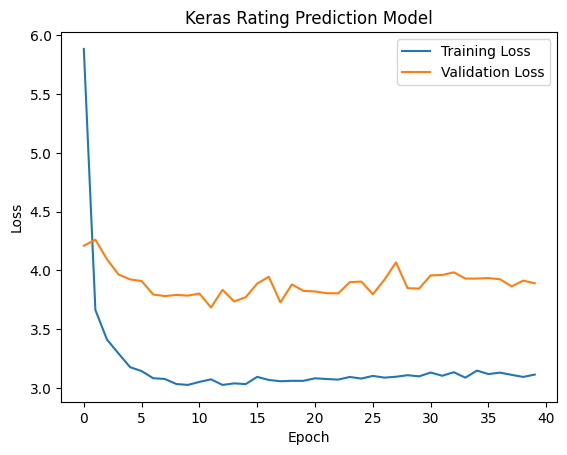

In [69]:
# Plot training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Keras Rating Prediction Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

predictions = loaded_model.predict([test_data.userId, test_data.movieId])

true_ratings = test_data.rating.values

mse = mean_squared_error(true_ratings, predictions, squared=True)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

mae = mean_absolute_error(true_ratings, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

631/631 [==============================] - 0s 519us/step
Mean Squared Error (MSE): 1.4147814765719564
Root Mean Squared Error (RMSE): 1.189445869542602
Mean Absolute Error (MAE): 0.8363086151894751


# Section 3: Visualization

<Axes: title={'center': 'Scatterplot of PCA Result for movie_embedding Weights'}, xlabel='Principal Component 1 (PC1)', ylabel='Principal Component 2 (PC2)'>

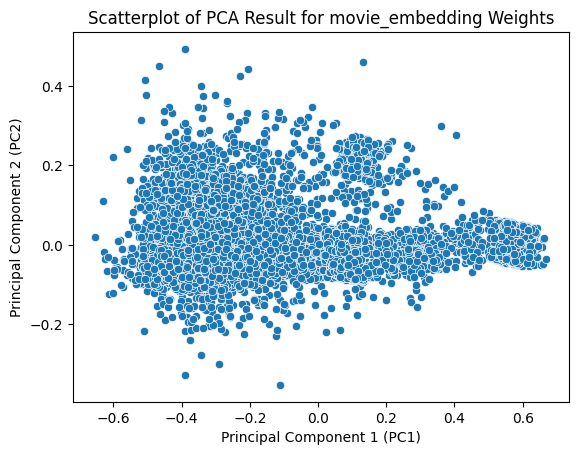

In [63]:
movie_em = model.get_layer("movie_emb")
movie_em_weights = movie_em.get_weights()[0]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(movie_em_weights)
plt.title('Scatterplot of PCA Result for movie_embedding Weights')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])

<Axes: title={'center': 'Scatterplot of t-SNE Result for movie_embedding Weights'}, xlabel='Dimension 1', ylabel='Dimension 2'>

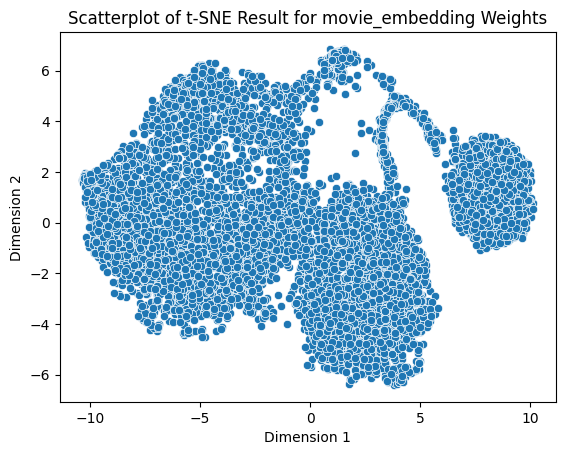

In [64]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(movie_em_weights)
plt.title('Scatterplot of t-SNE Result for movie_embedding Weights')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

# Section 4: Predictions

## Making recommendations for a single user.
Ex. user 1. This user has been encoded with the label 0 in our model. Therefore we must encode the input first before making predictions, otherwise we would be getting predictions for the wrong user and the model could even raise an `Error`.

In [65]:
def recommend(user_id):
    movie_data = np.array(list(set(ratings_df.movieId)))
    user = np.array([user_id for _ in range(len(movie_data))])

    #movie_data = movie_encoder.transform(movie_data)
    user = user_encoder.transform(user)

    predictions = model.predict([user, movie_data])

    prediction_indices = np.argsort(predictions.flatten())[::-1]

    top_5 = prediction_indices[:5]
    a = movie_encoder.inverse_transform(top_5)

    return movies_df[movies_df["movieId"].isin(a)]

In [66]:
recommend(1)

304/304 [==============================] - 0s 531us/step


,movieId,title,genres
883,1178,Paths of Glory (1957),Drama|War
1725,2318,Happiness (1998),Comedy|Drama
2279,3022,"General, The (1926)",Comedy|War
2452,3265,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller
4396,6460,"Trial, The (Procès, Le) (1962)",Drama
